In [1]:
import os

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy.io import loadmat

In [3]:
path = os.path.expanduser(f"~/storage1/projects/IPP_WANG/src/interareal/")

In [4]:
area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "8m",
    "5",
    "8l",
    "TEO",
    "2",
    "F1",
    "STPc",
    "7A",
    "46d",
    "10",
    "9/46v",
    "9/46d",
    "F5",
    "TEpd",
    "PBr",
    "7m",
    "7B",
    "F2",
    "STPi",
    "PROm",
    "F7",
    "8B",
    "STPr",
    "24c",
]
nareas = len(area_names)
iter_ = range(nareas)

### Connectivity weights FLN

In [5]:
data = np.load(os.path.join(path, "markov2014.npy"), allow_pickle=True).all()

In [6]:
FLN, Distances, Hierarchy = data["FLN"], data["Distances"], data["Hierarchy"]

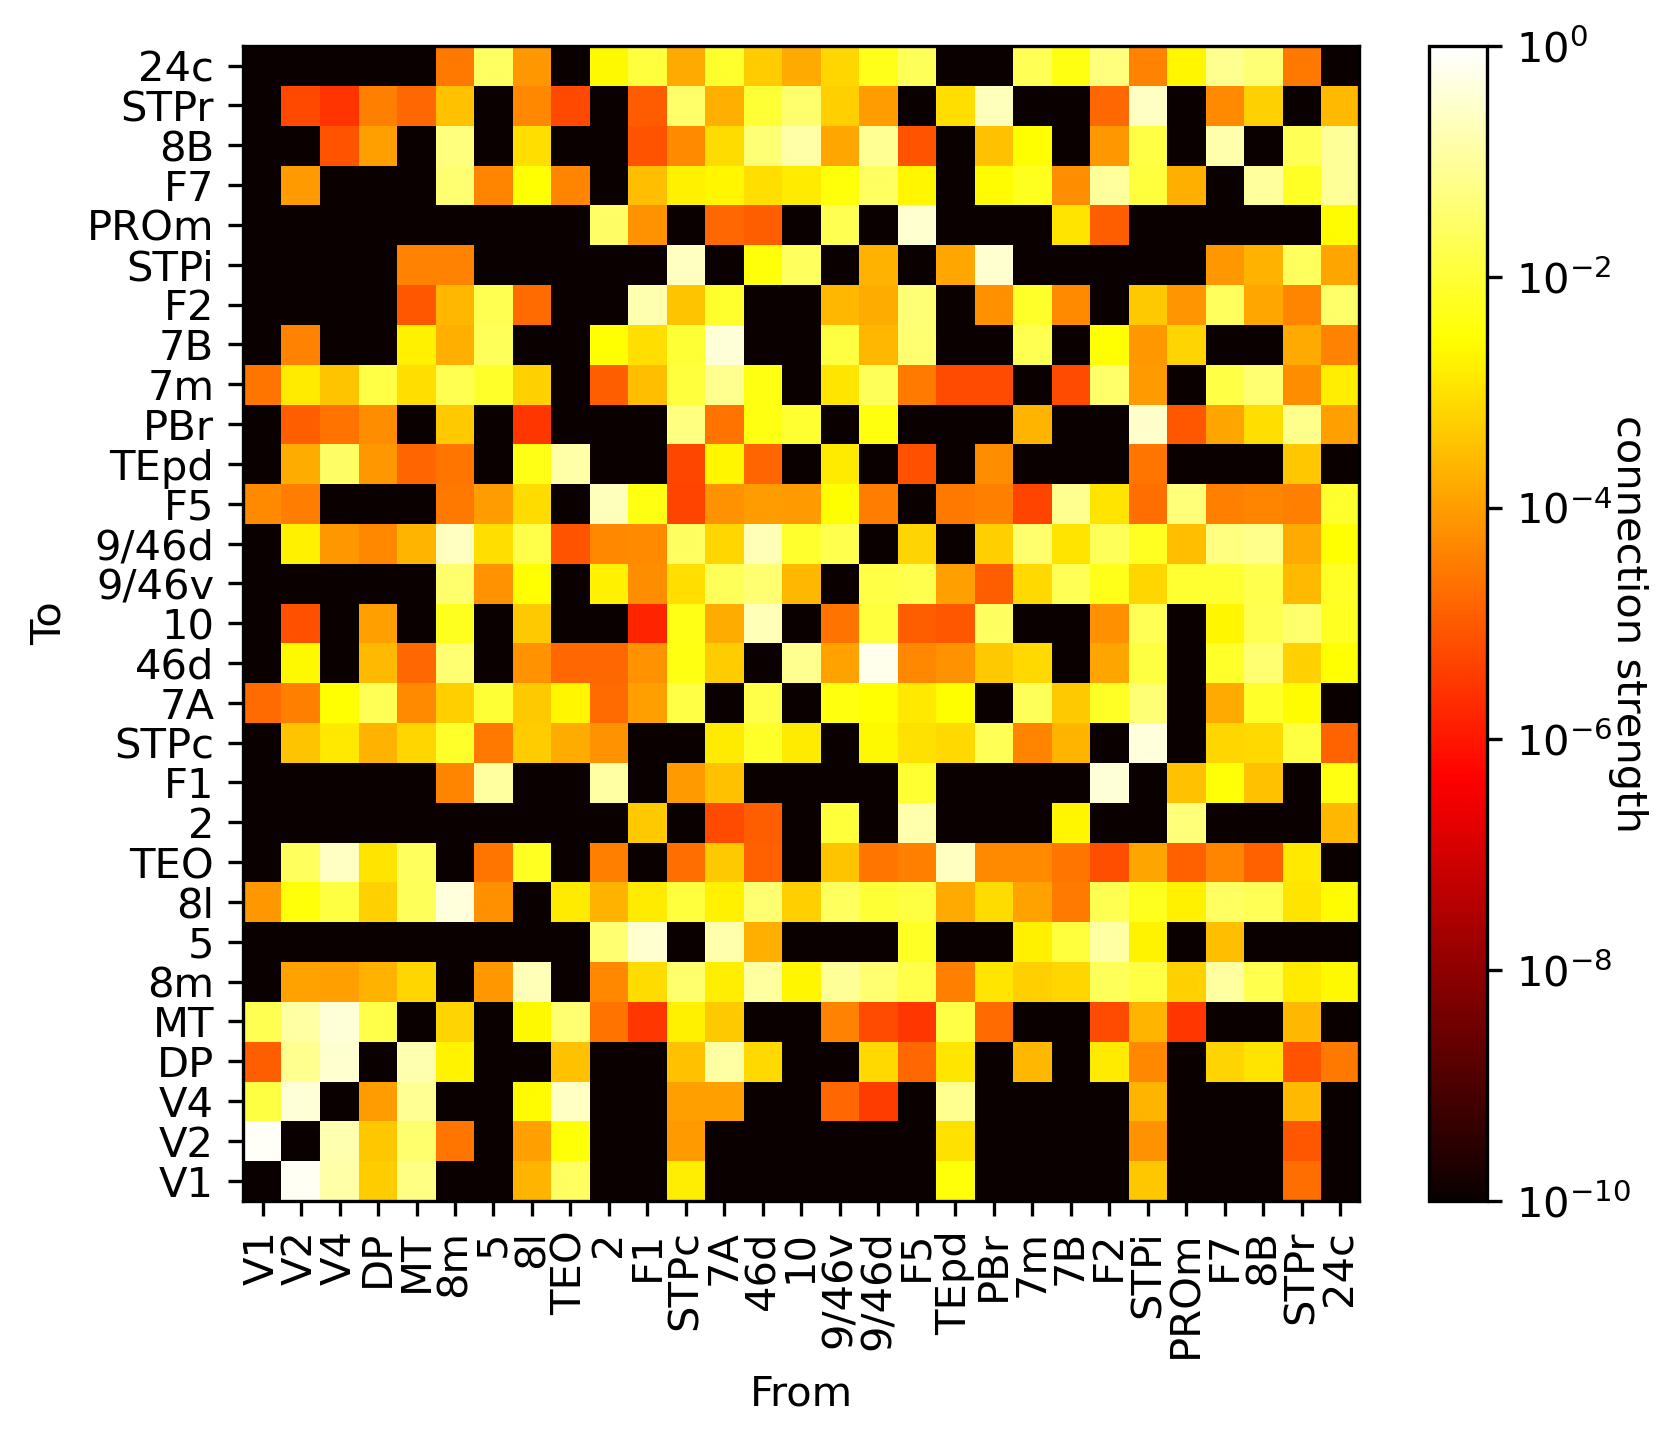

In [7]:
plt.figure(figsize=(6, 5), dpi=300)

im = plt.imshow(
    FLN + 1e-10,
    aspect="auto",
    origin="lower",
    cmap="hot",
    norm=colors.LogNorm(vmin=1e-10, vmax=1),
)
cbar = plt.colorbar(im)
cbar.set_label("connection strength", rotation=270)
plt.xticks(iter_, area_names, rotation=90)
plt.yticks(iter_, area_names)
plt.xlabel("From")
plt.ylabel("To")

plt.savefig("figures/logFLN.pdf")

In [8]:
"""
plt.figure(figsize=(6, 5), dpi=300)
logFLN = np.log(FLN)
masked_array = np.ma.array(logFLN, mask=np.isnan(logFLN))
cmap = matplotlib.cm.get_cmap("hot").copy()
cmap.set_bad('black')
plt.imshow(logFLN, aspect="auto", origin="lower", cmap=cmap)
cbar = plt.colorbar()
cbar.set_label('log(FLN)', rotation=270)
plt.xticks(iter_, area_names, rotation=90);
plt.yticks(iter_, area_names);
plt.xlabel("From")
plt.ylabel("To")

plt.savefig("figures/logFLN.eps")
""";

/tmp/ipykernel_195194/2662808291.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("copper").copy()


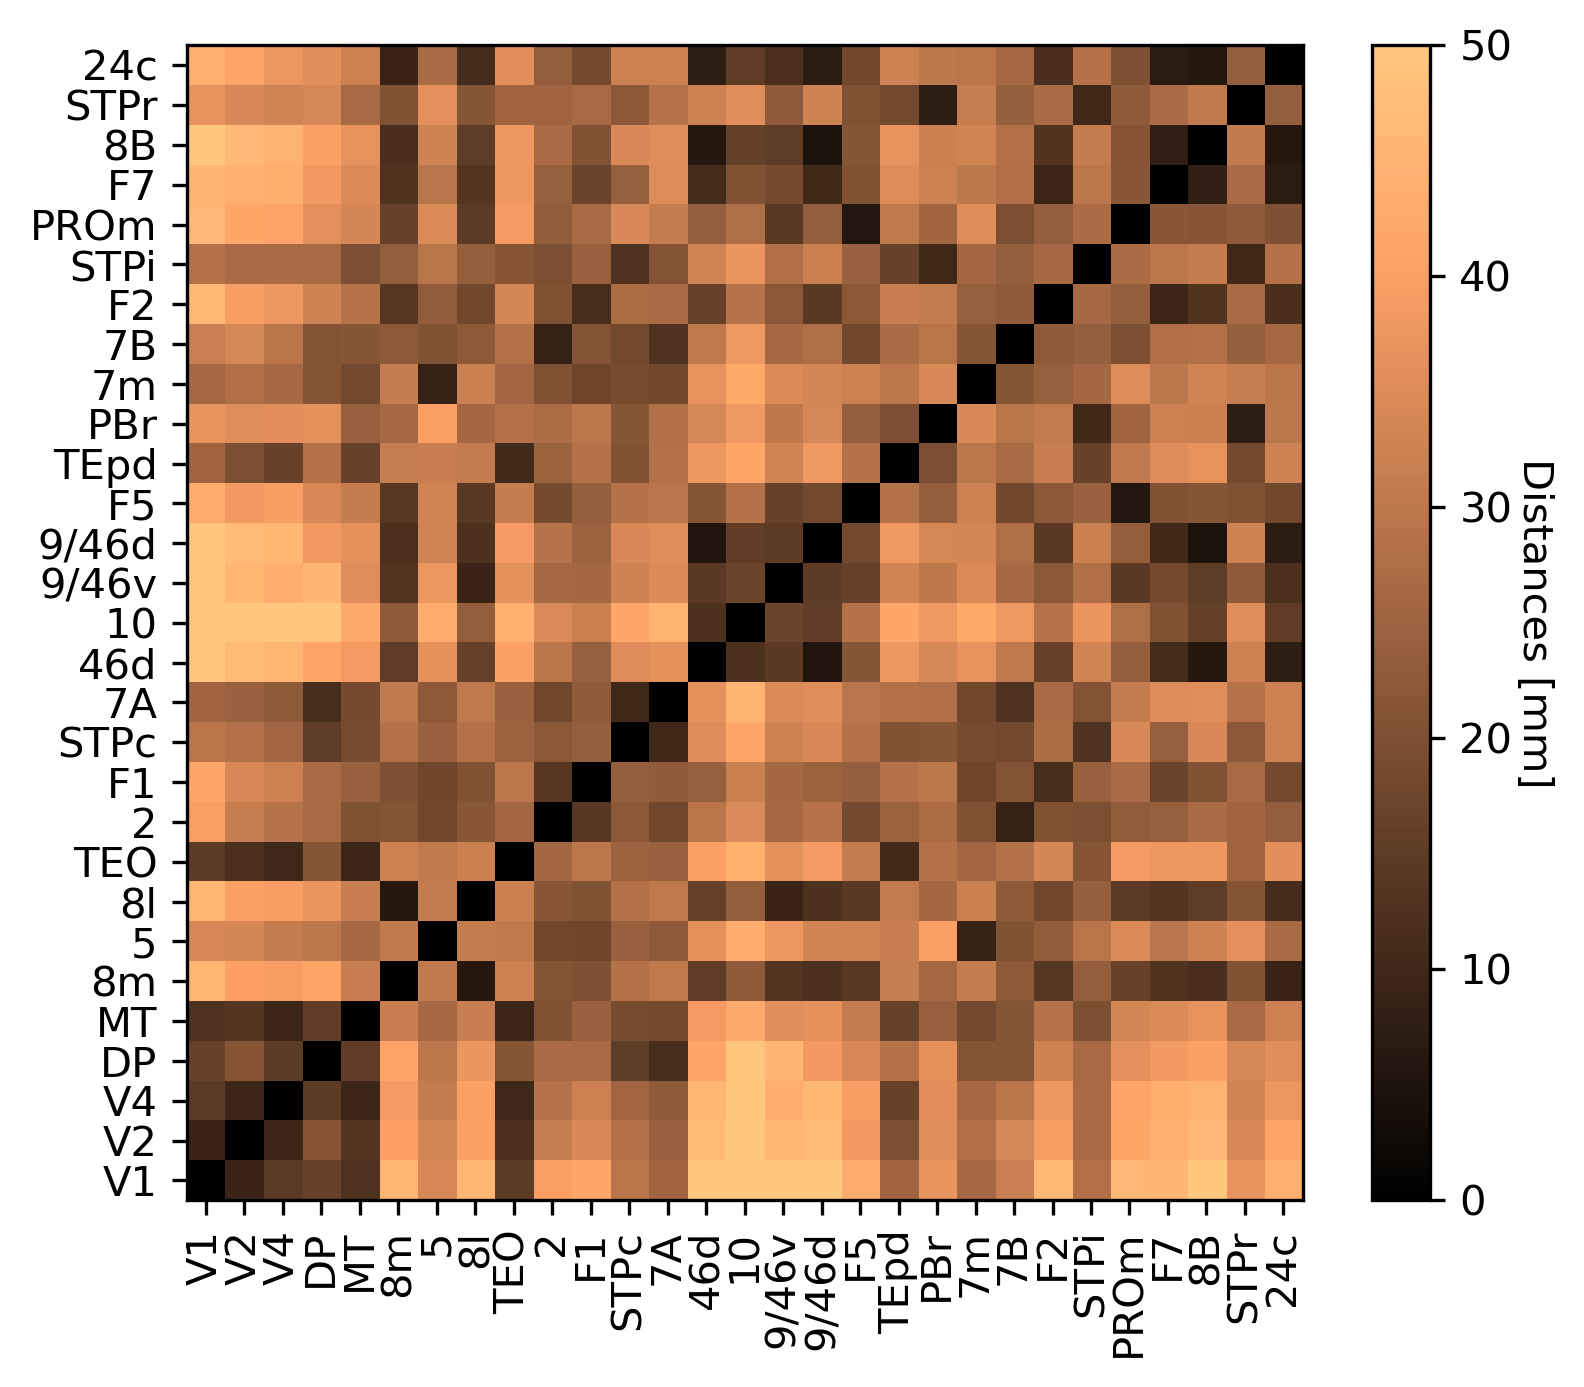

In [9]:
plt.figure(figsize=(6, 5), dpi=300)
masked_array = np.ma.array(Distances, mask=np.isnan(Distances))
cmap = matplotlib.cm.get_cmap("copper").copy()
cmap.set_bad("black")
plt.imshow(Distances, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=50)
cbar = plt.colorbar()
cbar.set_label("Distances [mm]", rotation=270, labelpad=10)
plt.xticks(iter_, area_names, rotation=90)
plt.yticks(iter_, area_names)


plt.savefig("figures/Distances.pdf")

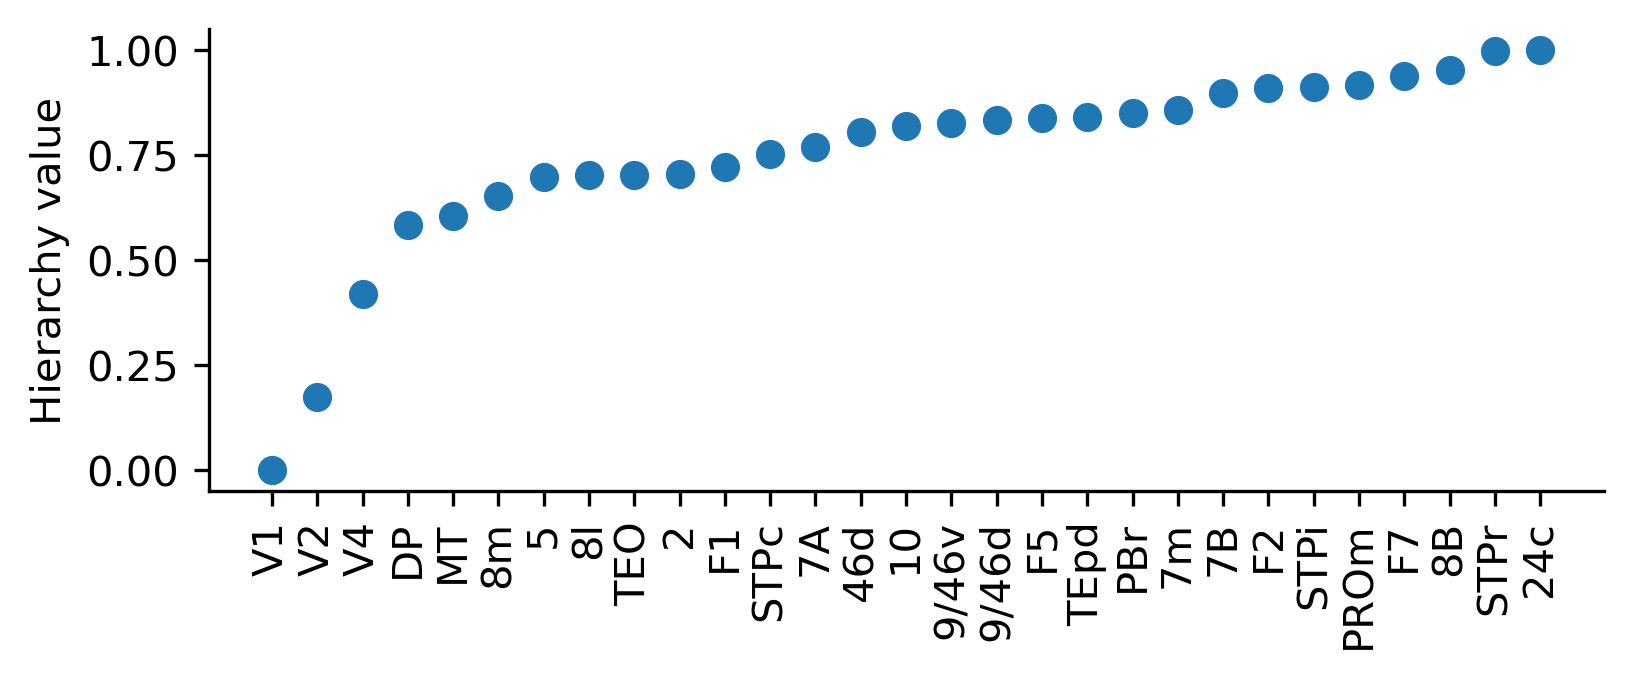

In [10]:
plt.figure(figsize=(6, 2), dpi=300)
ax = plt.subplot(111)
plt.plot(Hierarchy, "o")
plt.xticks(iter_, area_names, rotation=90)
plt.ylabel("Hierarchy value")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.savefig("figures/Hierarchy.pdf")

In [11]:
import pandas as pd

In [12]:
s = []
t = []
w = []
hs = []
ht = []

nrois = FLN.shape[0]

for i in range(nrois):
    for j in range(nrois):
        w += [FLN[i, j].data]
        s += [area_names[i]]
        t += [area_names[j]]
        hs += [Hierarchy[i]]
        ht += [Hierarchy[j]]

In [13]:
w = np.round(np.stack(w), 5)
s = np.stack(s)
t = np.stack(t)
hs = np.round(np.stack(hs).squeeze(), 4)
ht = np.round(np.stack(ht).squeeze(), 4)

In [14]:
FLN_DF = pd.DataFrame(
    np.stack((w, s, t, hs, ht), axis=1),
    columns=["weight", "source", "target", "hierachy_source", "hierachy_target"],
)

In [21]:
FLN_DF.to_csv("../data/MARKOV.csv", index=False)

In [22]:
pd.read_csv(
    "../data/MARKOV.csv",
)

,weight,source,target,hierachy_source,hierachy_target
0,0.00000,V1,V1,0.0,0.0000
1,0.73216,V1,V2,0.0,0.1752
2,0.12773,V1,V4,0.0,0.4201
3,0.00049,V1,DP,0.0,0.5842
4,0.05885,V1,MT,0.0,0.6062
...,...,...,...,...,...
836,0.00220,24c,PROm,1.0,0.9172
837,0.08047,24c,F7,1.0,0.9388
838,0.04287,24c,8B,1.0,0.9537
839,0.00003,24c,STPr,1.0,0.9973


In [90]:
def create_regions_mapping(regions: list):

    nregions = len(regions)

    return dict(zip(regions, range(nregions)))


def to_mat(df: pd.DataFrame, as_xr: bool = False):

    # Check if DF contains source and target columns
    assert ("source" in df.columns) and ("target" in df.columns)

    # Get sources and targets
    source, target = df.source.values, df.target.values

    # Get unique names
    regions = np.unique(np.concatenate((source, target)))
    # Number of regions
    nregions = len(regions)
    # Create encoding from regions to a given index
    mapping = create_regions_mapping(regions)
    # Allocate matrix
    FLN = np.empty((nregions, nregions))
    # Fill values
    FLN = FLN[
        np.ix_(FLN_DF.source.map(mapping), FLN_DF.target.map(mapping).values)
    ].ravel()
    FLN = FLN_DF.weight.values.astype(float)
    FLN = FLN.reshape(nregions, nregions)

    if as_xr:
        FLN = xr.DataArray(FLN, dims=("sources", "targets"), coords=(regions, regions))
    return FLN

In [91]:
import xarray as xr

In [92]:
to_mat(FLN_DF, True)

<xarray.DataArray (sources: 29, targets: 29)>
array([[0.0000e+00, 7.3216e-01, 1.2773e-01, 4.9000e-04, 5.8850e-02,
        0.0000e+00, 0.0000e+00, 2.1000e-04, 2.7030e-02, 0.0000e+00,
        0.0000e+00, 1.6500e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6300e-03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3000e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e-05, 0.0000e+00],
       [7.6356e-01, 0.0000e+00, 1.5133e-01, 4.2000e-04, 3.5730e-02,
        2.0000e-05, 0.0000e+00, 1.1000e-04, 3.2700e-03, 0.0000e+00,
        0.0000e+00, 9.0000e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0500e-03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e-05, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e-05, 0.0000e+00],
       [1.3050e-02, 3.9085e-01, 0.0000e+00, 1.0000e-04, 8.4680e-02,
        0.0000e+00, 0.0000e+00, 2.4200e-03, 2.3782e-01, 0.0000e+00,
        0.0000e+00, 1.1000e-04, 1.0000e-04, 0.0000e+00, 0.0000e+00,
        2.0000e-05, 0.0000e+00, 0.0000e+00, 7.4880e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3000e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.6000e-04, 0.0000e+00],
       [1.0000e-05, 7.9020e-02, 3.3761e-01, 0.0000e+00, 1.6242e-01,
        1.9300e-03, 0.0000e+00, 0.0000e+00, 3.4000e-04, 0.0000e+00,
...
        5.6200e-03, 6.0000e-05, 9.8960e-02, 1.1630e-02, 1.8000e-04,
        0.0000e+00, 1.0377e-01, 6.5700e-03, 9.3540e-02],
       [0.0000e+00, 0.0000e+00, 1.0000e-05, 1.0000e-04, 0.0000e+00,
        4.9100e-02, 0.0000e+00, 9.4000e-04, 0.0000e+00, 0.0000e+00,
        1.0000e-05, 5.0000e-05, 8.9000e-04, 3.9960e-02, 1.3197e-01,
        1.5000e-04, 8.7000e-02, 1.0000e-05, 0.0000e+00, 3.5000e-04,
        2.6500e-03, 0.0000e+00, 9.0000e-05, 1.4380e-02, 0.0000e+00,
        1.5123e-01, 0.0000e+00, 1.9140e-02, 9.3710e-02],
       [0.0000e+00, 1.0000e-05, 0.0000e+00, 4.0000e-05, 2.0000e-05,
        3.5000e-04, 0.0000e+00, 5.0000e-05, 1.0000e-05, 0.0000e+00,
        1.0000e-05, 3.0260e-02, 1.9000e-04, 1.0100e-02, 3.2960e-02,
        5.4000e-04, 1.0000e-04, 0.0000e+00, 9.6000e-04, 1.9856e-01,
        0.0000e+00, 0.0000e+00, 2.0000e-05, 2.4014e-01, 0.0000e+00,
        5.0000e-05, 6.0000e-04, 0.0000e+00, 2.7000e-04],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e-05, 2.5570e-02, 8.0000e-05, 0.0000e+00, 2.2400e-03,
        1.1170e-02, 1.5000e-04, 7.9600e-03, 4.8000e-04, 1.5000e-04,
        7.5000e-04, 5.1100e-03, 2.2130e-02, 0.0000e+00, 0.0000e+00,
        1.9520e-02, 4.3200e-03, 4.9110e-02, 4.0000e-05, 2.2000e-03,
        8.0470e-02, 4.2870e-02, 3.0000e-05, 0.0000e+00]])
Coordinates:
  * sources  (sources) object '10' '2' '24c' '46d' '5' ... 'TEpd' 'V1' 'V2' 'V4'
  * targets  (targets) object '10' '2' '24c' '46d' '5' ... 'TEpd' 'V1' 'V2' 'V4'

In [68]:
source, target = FLN_DF.source.values, FLN_DF.target.values

In [69]:
regions = np.unique(np.concatenate((source, target)))

In [70]:
mapping = create_regions_mapping(regions)

In [71]:
FLN_DF.target.map(mapping)

0      26
1      27
2      28
3      13
4      18
       ..
836    20
837    17
838     8
839    23
840     2
Name: target, Length: 841, dtype: int64

In [72]:
FLN = np.empty((29, 29))

In [73]:
FLN = FLN[np.ix_(FLN_DF.source.map(mapping), FLN_DF.target.map(mapping).values)].ravel()

In [80]:
FLN = FLN_DF.weight.values.astype(float)

In [81]:
FLN = FLN.reshape(29, 29)

Text(0, 0.5, 'To')

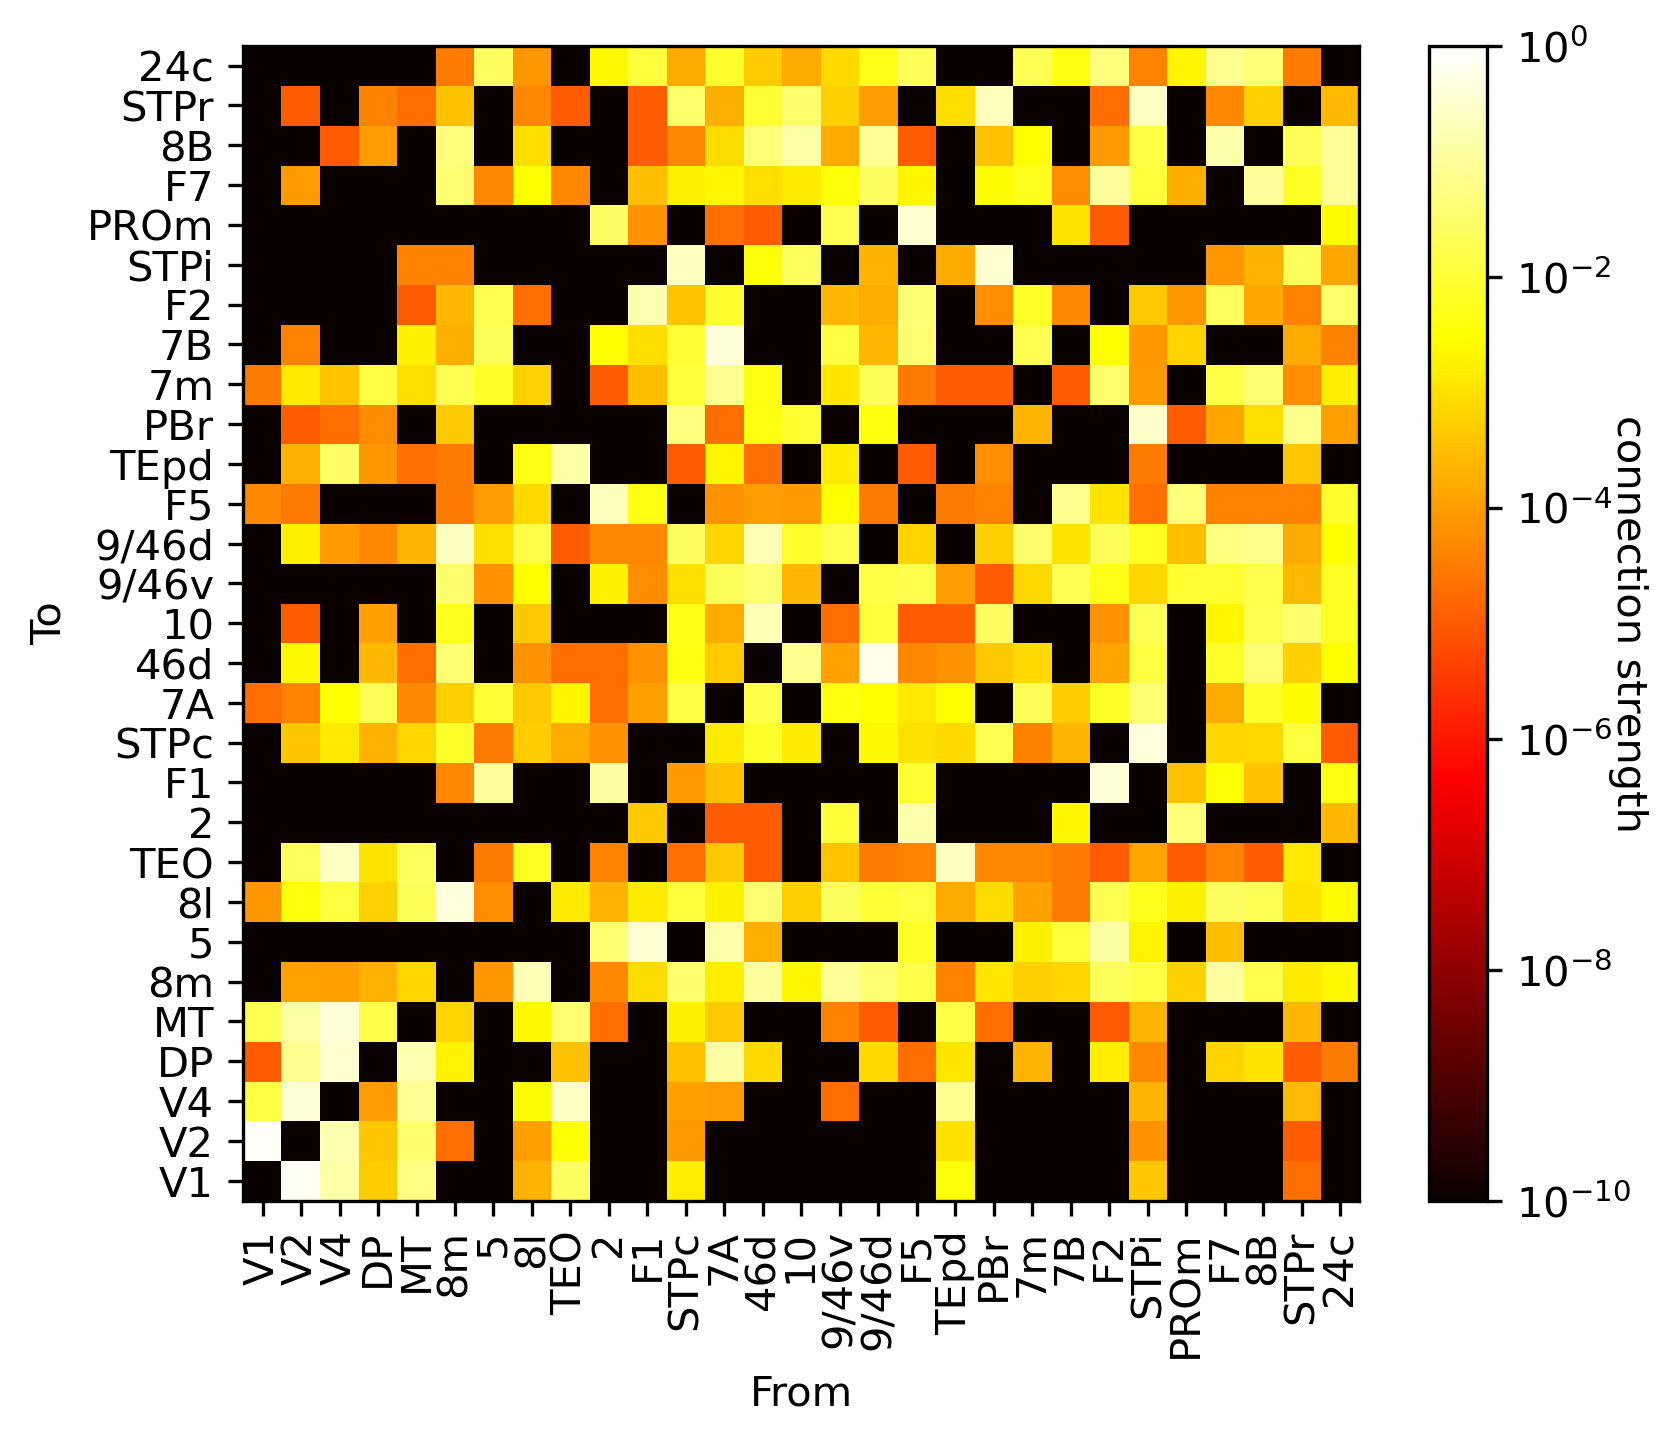

In [82]:
plt.figure(figsize=(6, 5), dpi=300)

im = plt.imshow(
    FLN + 1e-10,
    aspect="auto",
    origin="lower",
    cmap="hot",
    norm=colors.LogNorm(vmin=1e-10, vmax=1),
)
cbar = plt.colorbar(im)
cbar.set_label("connection strength", rotation=270)
plt.xticks(iter_, area_names, rotation=90)
plt.yticks(iter_, area_names)
plt.xlabel("From")
plt.ylabel("To")

In [77]:
FLN

array([['0.0', '0.73216', '0.12773', '0.00049', '0.05885', '0.0', '0.0',
        '0.00021', '0.02703', '0.0', '0.0', '0.00165', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.00363', '0.0', '0.0', '0.0',
        '0.0', '0.00043', '0.0', '0.0', '0.0', '2e-05', '0.0'],
       ['0.76356', '0.0', '0.15133', '0.00042', '0.03573', '2e-05',
        '0.0', '0.00011', '0.00327', '0.0', '0.0', '9e-05', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.00105', '0.0', '0.0', '0.0',
        '0.0', '7e-05', '0.0', '0.0', '0.0', '1e-05', '0.0'],
       ['0.01305', '0.39085', '0.0', '0.0001', '0.08468', '0.0', '0.0',
        '0.00242', '0.23782', '0.0', '0.0', '0.00011', '0.0001', '0.0',
        '0.0', '2e-05', '0.0', '0.0', '0.07488', '0.0', '0.0', '0.0',
        '0.0', '0.00023', '0.0', '0.0', '0.0', '0.00026', '0.0'],
       ['1e-05', '0.07902', '0.33761', '0.0', '0.16242', '0.00193',
        '0.0', '0.0', '0.00034', '0.0', '0.0', '0.00034', '0.11797',
        '0.00076', '0.0', '0.0', '0.0